## Source Panel Method

In [13]:
import os
import math
import numpy as np
from scipy import integrate
from matplotlib import pyplot as py
%matplotlib inline

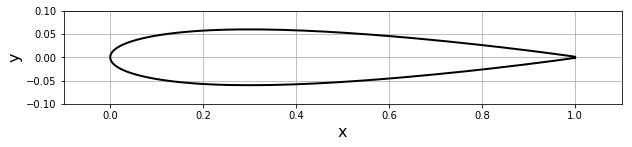

In [14]:
#read airfoil geometry
naca_filepath = os.path.join('naca0012.dat')
with open (naca_filepath, 'r') as file_name:
    x, y = np.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)
    
#plot geometry 
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(x, y, color='k', linestyle='-', linewidth=2)
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.1);

In [15]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya +yb) / 2 #control point (center point)
        self.length = math.sqrt((xb-xa)**2 + (yb-ya)**2)
        
        
        #orientation of the panel
        if xb - xa <= 0.0:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = math.pi + math.acos(-(yb- ya) / self.length)
            
            
        #location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.0 #source strength
        self.vt = 0.0 #tangential velocity
        self.cp = 0.0 #pressure coefficient

In [16]:
def define_panels(x, y, N=40):
    
    R = (x.max() - x.min()) / 2 #radius of the circle
    x_center = (x.max() +x.min()) / 2 #xcoordinate of the center
    
    x_circle = x_center + R * np.cos(np.linspace(0.0, 2 * math.pi, N + 1))
    
    x_ends = np.copy(x_circle) #projection of the x coordinate on the surface
    y_ends = np.empty_like(x_ends) #initialization of the y coord np array
    
    x, y = np.append(x, x[0]), np.append(y, y[0]) #extend arrays using
    
    #computes the y coord of the end pts
    I = 0
    for i in range(N):
        while I < len(x) -1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] +b
    y_ends[N] = y_ends[0]
    
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
        
    return panels

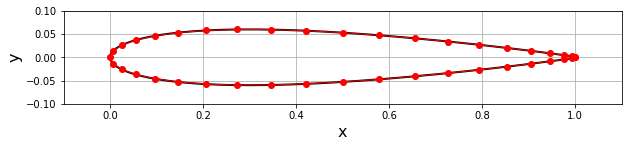

In [17]:
N = 40
panels = define_panels(x, y, N)

#plot geometry 
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(x, y, color='k', linestyle='-', linewidth=2)
py.plot(np.append([panel.xa for panel in panels], panels[0].xa),
       np.append([panel.ya for panel in panels], panels[0].ya),
       linestyle='-', linewidth=1, marker='o', markersize=6, color='r')
py.axis('scaled', adjustable='box')
py.xlim(-0.1,1.1)
py.ylim(-0.1,0.1);

## Freestream Conditions

In [18]:
class Freestream:
    
    def __init__(self, u_inf=1.0, alpha=0.0):
        
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)

In [19]:
u_inf = 1.0
alpha = 0.0 #angle of attack in degrees
freestream = Freestream(u_inf, alpha)

In [20]:
def integral(x, y, panel, dxdz, dydz):
    
    def integrand(s):
        return (((x - (panel.xa - math.sin(panel.beta) * s)) * dxdz +
                (y - (panel.ya + math.cos(panel.beta) * s)) * dydz) /
               ((x - (panel.xa - math.sin(panel.beta) * s))**2 +
               (y - (panel.ya + math.cos(panel.beta) * s))**2))
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [21]:
def build_matrix(panels):
    
    N = len(panels)
    A = np.empty((N,N), dtype = float)
    np.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / math.pi * integral(p_i.xc, p_i.yc, p_j,
                                                  math.cos(p_i.beta),
                                                  math.sin(p_i.beta))
    return A

def build_rhs(panels, freestream):
    
    b = np. empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
        
    return b

In [22]:
A = build_matrix(panels)
b = build_rhs(panels, freestream)

In [24]:
#solve the linear system
sigma = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

In [25]:
def get_tangential_velocity(panels, freestream):
    
    N = len(panels)
    A = np.empty((N, N), dtype=float)
    np.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / math.pi * integral(p_i.xc, p_i.yc, p_j,
                                                   -math.sin(p_i.beta),
                                                   math.cos(p_i.beta))
    
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    sigma = np.array([panel.sigma for panel in panels])
    
    vt = np.dot(A, sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [26]:
get_tangential_velocity(panels, freestream)

In [27]:
def get_pressure_coefficient(panels, freestream):
  
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [28]:
get_pressure_coefficient(panels, freestream)

In [30]:
#plot therohetical solution

voverVsquared=np.array([0.0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411,
                           1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044,
                           0.956, 0.906, 0.0])
print(voverVsquared)

xtheo=np.array([0.0, 0.5, 1.25, 2.5, 5.0, 7.5, 10.0, 15.0, 20.0, 25.0, 30.0,
                   40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 95.0, 100.0])
xtheo /= 100
print(xtheo)

[ 0.     0.64   1.01   1.241  1.378  1.402  1.411  1.411  1.399  1.378
  1.35   1.288  1.228  1.166  1.109  1.044  0.956  0.906  0.   ]
[ 0.      0.005   0.0125  0.025   0.05    0.075   0.1     0.15    0.2     0.25
  0.3     0.4     0.5     0.6     0.7     0.8     0.9     0.95    1.    ]


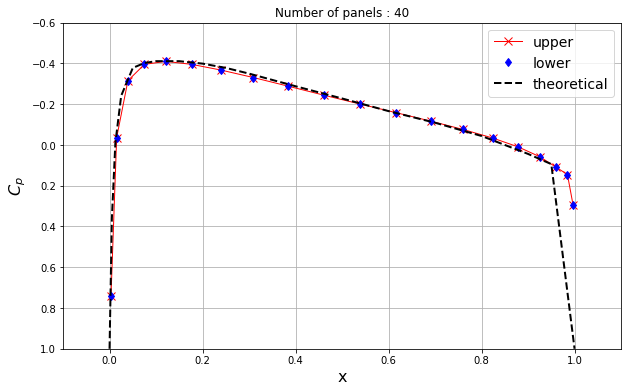

In [31]:
#plot surface pressures

py.figure(figsize=(10, 6))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('$C_p$', fontsize=16)
py.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper',
            color='r', linewidth=1, marker='x', markersize=8)
py.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label='lower',
            color='b', linewidth=0, marker='d', markersize=6)
py.plot(xtheo, 1-voverVsquared,
            label='theoretical',
            color='k', linestyle='--',linewidth=2)
py.legend(loc='best', prop={'size':14})
py.xlim(-0.1, 1.1)
py.ylim(1.0, -0.6)
py.title('Number of panels : {}'.format(N));

## Streamlines onto a mesh grid

In [32]:
def get_velocity_field(panels, freestream, X, Y):
  
    # freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * np.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * np.ones_like(X, dtype=float)
    # add the contribution from each source (superposition powers!!!)
    vec_intregral = np.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 1.0, 0.0)
        v += panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 0.0, 1.0)
    
    return u, v

In [33]:
# define a mesh grid
nx, ny = 20, 20  # number of points in the x and y directions
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = np.meshgrid(np.linspace(x_start, x_end, nx),
                      np.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)

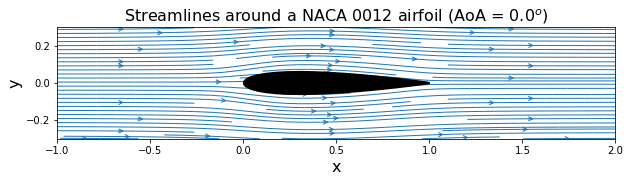

In [34]:
width = 10
py.figure(figsize=(width, width))
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
py.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
py.axis('scaled', adjustable='box')
py.xlim(x_start, x_end)
py.ylim(y_start, y_end)
py.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(alpha),
             fontsize=16);

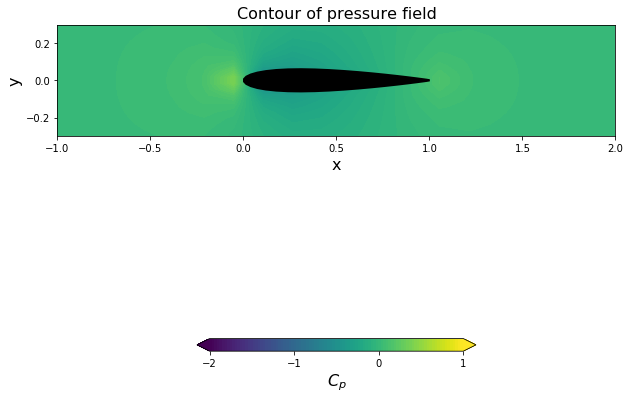

In [36]:
#computing pressure field

cp = 1.0 - (u**2 + v**2) / freestream.u_inf**2

width = 10
py.figure(figsize=(width, width))
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
contf = py.contourf(X, Y, cp,
                        levels=np.linspace(-2.0, 1.0, 100), extend='both')
cbar = py.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
py.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
py.axis('scaled', adjustable='box')
py.xlim(x_start, x_end)
py.ylim(y_start, y_end)
py.title('Contour of pressure field', fontsize=16);